
## Problem statement and Overview

[Data Source](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

The dataset stores information about 5000 people that have been surveyed about their demographics, biologic parameter and behaviours. We will use this data to gain insights about the factors that influence the probability of having a Heart Attack. 

###### This notebook is structured as follows: 
- Data Extraction and Exploration: we will observe the data, trying to gather an idea of the variables and their distributions
- Data Transformation: we will fill missing values and rescale our variables in a more model-oriented form
- Data Modelling: A Linear and a Tree-based classifiers will be fitted, in order to assess what are the features that mostly influence the target variable (and their significance) 
- Final Visualization: Loading transformed and visualizing some of the insights gained during the research


#### Data Exploration

A simple look at the data, to visualize feature distribution and basic statistics

In [0]:
# File location and type
file_location = "/FileStore/tables/healthcare_dataset_stroke_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

#Displaying a portion of the DataFrame
df.show(5)
#NaN encoded as strings -> we need to transform them. 


+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [0]:
# Describing the DF
# Getting unique values for each column. Can we dichotimize any variables? 
pdf = df.select('*').toPandas()

pdf.describe()

# AGE: has 104 unique values 
# BMI has mode = NULL

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110,5110,5110,5110,5110
unique,5110,3,104,2,2,2,5,2,3979,419,4,2
top,9046,Female,78,0,0,Yes,Private,Urban,93.88,N/A,never smoked,0
freq,1,2994,102,4612,4834,3353,2925,2596,6,201,1892,4861


In [0]:
# Describing Target variable
display(df.groupBy("stroke").count())

stroke,count
0,4861
1,249


In [0]:
# Collecting distinct values for variables with few categories -> Let's see if we can operate some transformations 
#GENDER
display(df.groupBy("gender").count().orderBy("count"))
# Can be approximated to a boolean 

gender,count
Other,1
Male,2115
Female,2994


In [0]:
# SMOKING STATUS
display(df.groupBy("smoking_status").count().orderBy("count"))
#Has null values encoded as "unknown" 

smoking_status,count
smokes,789
formerly smoked,885
Unknown,1544
never smoked,1892


In [0]:
# WORK_TYPE
# SMOKING STATUS
display(df.groupBy("work_type").count().orderBy("count"))
#Has null values encoded as "unknown" 
# Can't really sort the values. It needs to stay a factor

work_type,count
Never_worked,22
Govt_job,657
children,687
Self-employed,819
Private,2925


In [0]:
# Some troubles converting continuous variables with Python -> switching to sql
# Creating a table
temp_table_name = "healthcare_dataset_stroke_data_csv"

df.createOrReplaceTempView(temp_table_name)
temp_continuous = spark.sql("select age::float as age, nullif(bmi,'N/A')::float as bmi, avg_glucose_level::float as avg_glucose_level from healthcare_dataset_stroke_data_csv").toPandas()
temp_continuous.describe()
 
#Age has decimal values
#Glucose level looks concentrated around the mean, with a long right tail.
#bmi looks gaussian, with a long right tail and several NULL values. 

,age,bmi,avg_glucose_level
count,5110.000000,4909.000000,5110.000000
mean,43.226616,28.893234,106.147675
std,22.612646,7.854067,45.283562
min,0.080000,10.300000,55.119999
25%,25.000000,23.500000,77.244999
50%,45.000000,28.100000,91.884998
75%,61.000000,33.099998,114.089996
max,82.000000,97.599998,271.739990


In [0]:
from pyspark.sql.functions import col, round, lit
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Visualizing the absolute frequence of observation grouped by age
result_df = df.withColumn("age_bucket", round(col("age") / lit(10)) * lit(10)) \
    .groupBy("age_bucket") \
    .agg(F.countDistinct("id").alias("absolute_frequence")) \
    .orderBy("age_bucket")

display(result_df)

age_bucket,absolute_frequence
0.0,255
10.0,444
20.0,537
30.0,609
40.0,688
50.0,798
60.0,752
70.0,509
80.0,518


In [0]:
from pyspark.sql.functions import col, countDistinct, round

# Visualizing the absolute frequence of observation by BMI
result_df = df.withColumn("bmi", round(col("bmi").cast("float"), 0)) \
    .groupBy("bmi") \
    .agg(countDistinct("id").alias("absolute_frequence")) \
    .orderBy("bmi")

display(result_df)
# it looks like the bmi, once clenaed from extreme values follows a Gaussian distribution

bmi,absolute_frequence
null,201
10.0,1
11.0,1
12.0,3
13.0,5
14.0,21
15.0,32
16.0,68
17.0,92
18.0,114


In [0]:
#What's the distribution of missing BMI info across the target variable?
from pyspark.sql.functions import col, when, countDistinct

result_df = df.withColumn("null_bmi",
    when(col("bmi") == 'N/A', 'BMI null').otherwise('BMI available')
).groupBy(
    col("null_bmi"),
    col("stroke")
).agg(countDistinct("id").alias("count_distinct_id"))

display(result_df) 
# We can't exclude observation with null bmi since too many positive targets are involved. -> We need to impute.

null_bmi,stroke,count_distinct_id
BMI available,0,4700
BMI null,0,161
BMI null,1,40
BMI available,1,209


In [0]:
%sql
select
  round(avg_glucose_level :: float, -1) as avg_glucose_level,
  count(distinct id) as absolute_frequence
from
  healthcare_dataset_stroke_data_csv
group by
  1
order by
  1

In [0]:
# Perform aggregation and ordering
result_df = df.withColumn("avg_glucose_level", round(df["avg_glucose_level"].cast("float"), -1)) \
              .groupBy("avg_glucose_level") \
              .agg(countDistinct("id").alias("absolute_frequence")) \
              .orderBy("avg_glucose_level")

display(result_df)

avg_glucose_level,absolute_frequence
60.0,446
70.0,668
80.0,883
90.0,805
100.0,613
110.0,453
120.0,242
130.0,134
140.0,93
150.0,75



#### Data Transformation

- Changing variable types and formats
- Imputing missing values for BMI and smoking level

In [0]:
# changing formats and types
query = """select distinct 
id,
(gender = 'Female')::int as is_female, --transforming gender -> dichotomic
round(age::float,0) as age,
hypertension::int as hypertension,
heart_disease::int as heart_disease,
(ever_married = 'Yes')::int as ever_married,
work_type,
(Residence_type = 'Urban')::int as urban_residence,
avg_glucose_level::float,
nullif(bmi,'N/A')::float as bmi,
case when smoking_status = 'smokes' then 3 
  when smoking_status = 'formerly smoked' then 2 
  when smoking_status = 'never smoked' then 1 end as smoking_level, --3 levels + null
stroke::int as stroke
from `healthcare_dataset_stroke_data_csv`
                       """
clean_data = spark.sql(query)

# display(clean_data)

# checkign for errors
clean_data.toPandas().describe()

,is_female,age,hypertension,heart_disease,ever_married,urban_residence,avg_glucose_level,bmi,smoking_level,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,3566.000000,5110.000000
mean,0.585910,43.226616,0.097456,0.054012,0.656164,0.508023,106.147675,28.893234,1.690690,0.048728
std,0.492612,22.612730,0.296607,0.226063,0.475034,0.499985,45.283562,7.854067,0.810144,0.215320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.119999,10.300000,1.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.244999,23.500000,1.000000,0.000000
50%,1.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.884998,28.100000,1.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.089996,33.099998,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.739990,97.599998,3.000000,1.000000


In [0]:
#Random imputation of BMI via Gaussian Distribution 
#Detecting Outliers
import numpy as np


pandas_clean_data = clean_data.toPandas()
bottom_2_5 = np.percentile(pandas_clean_data.bmi.dropna(), 2.5)
top_97_5 = np.percentile(pandas_clean_data.bmi.dropna(), 97.5)
print("2.5% percentile: ",np.round(bottom_2_5,2), " -- 97.5% percentile: ", np.round(top_97_5,2))

#Estimating Mean and St. Deviation of the adjusted distribution 
mu = np.mean(pandas_clean_data.bmi[ (pandas_clean_data['bmi'] > bottom_2_5) & (pandas_clean_data['bmi'] < top_97_5) ])
sd = np.std(pandas_clean_data.bmi[ (pandas_clean_data['bmi'] > bottom_2_5) & (pandas_clean_data['bmi'] < top_97_5) ])
print("mean of the distribution: ", np.round(mu,2), " -- Std of the distribution: ", np.round(sd,2))

#Value imputation
n = pandas_clean_data['bmi'].isna().sum()
print("Missing bmi values: ", n)
fill = np.random.normal(mu, sd, n)
pandas_clean_data.bmi[pandas_clean_data['bmi'].isna()] = fill # = pandas_clean_data['bmi'].fillna(value = fill)

2.5% percentile:  16.4  -- 97.5% percentile:  46.43
mean of the distribution:  28.63  -- Std of the distribution:  6.5
Missing bmi values:  201


<command-672314515172179>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_clean_data.bmi[pandas_clean_data['bmi'].isna()] = fill # = pandas_clean_data['bmi'].fillna(value = fill)


In [0]:
# Now imputing Smoking_level with KNN imputer 

# Scaling our dataset to avoid distance issues
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Work type can't be encoded as ordered categorical variable -> we need to get its dummies
pandas_clean_data = pd.get_dummies(pandas_clean_data, columns=["work_type"], drop_first = True)


scaler = MinMaxScaler()
scaled_df = pandas_clean_data.drop(['stroke', 'id'], axis = 1)
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns = scaled_df.columns)

#Having a look at the partial result
scaled_df.head()

,is_female,age,hypertension,heart_disease,ever_married,urban_residence,avg_glucose_level,bmi,smoking_level,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,0.0,0.707317,0.0,1.0,1.0,0.0,0.856200,0.254265,1.0,0.0,1.0,0.0,0.0
1,0.0,0.963415,0.0,0.0,1.0,0.0,0.275367,0.162488,0.5,0.0,1.0,0.0,0.0
2,1.0,0.097561,0.0,0.0,0.0,1.0,0.257455,0.098809,NaN,0.0,1.0,0.0,0.0
3,1.0,0.926829,0.0,0.0,1.0,1.0,0.190056,0.186675,1.0,0.0,0.0,0.0,0.0
4,1.0,0.390244,0.0,0.0,0.0,1.0,0.046995,0.355649,0.0,0.0,0.0,1.0,0.0


In [0]:
# Actual imputation
from sklearn.impute import KNNImputer

#Basing the imputation on the 5 neareast neighbors 
imputer = KNNImputer(n_neighbors=5)

scaled_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns = scaled_df.columns)

# Dropping old column and appending new imputed column. Variable is scaled but it won't make any difference. 
pandas_clean_data = pandas_clean_data.drop('smoking_level', axis = 1)
pandas_clean_data = pd.concat([pandas_clean_data, scaled_df['smoking_level']], axis = 1)
scaled_df = pd.concat([scaled_df, pandas_clean_data['stroke']], axis = 1)

#Did we solve the problem? 
scaled_df.isna().any()
#Yes, no missing values are left

Out[34]: is_female                  False
age                        False
hypertension               False
heart_disease              False
ever_married               False
urban_residence            False
avg_glucose_level          False
bmi                        False
smoking_level              False
work_type_Never_worked     False
work_type_Private          False
work_type_Self-employed    False
work_type_children         False
stroke                     False
dtype: bool


#### Data Modelling
Fitting a classifier to understand the impact of each feature and testing for significance 

In [0]:
# Start fitting a logistic regression. This will help us evaluating feature importance and significance 
import statsmodels.api as sm


fit1 = sm.GLM(scaled_df['stroke'], scaled_df.drop(['stroke'], axis = 1), family = sm.families.Binomial())

# displaying fit and significance
results = fit1.fit()
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                            GLM   Df Residuals:                     5097
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -944.84
Date:                Mon, 11 Sep 2023   Deviance:                       1889.7
Time:                        14:45:41   Pearson chi2:                 9.46e+03
No. Iterations:                    22   Pseudo R-squ. (CS):            0.01951
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
is_female                 

In [0]:
# Fitting a decision tree classifier and evaluating feature importance

from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(scaled_df.drop(['stroke'], axis = 1), scaled_df['stroke'])

Out[36]: DecisionTreeClassifier()

Out[37]: <AxesSubplot:>

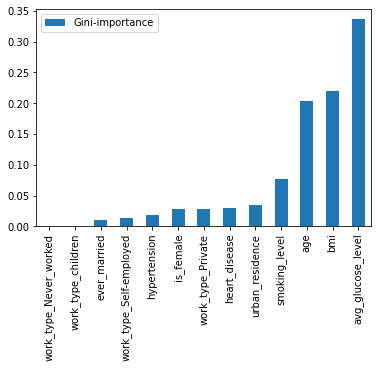

In [0]:
# Visualizing Feature Importance

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(scaled_df.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar')


#### Final Visualization

Loading Transformed data and Visualising features selected by the two models with their impact on Target

In [0]:
pandas_clean_data.head()

,id,is_female,age,hypertension,heart_disease,ever_married,urban_residence,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_level
0,56841,0,58.0,0,1,1,0,240.589996,31.400000,1,0,1,0,0,1.0
1,18937,0,79.0,0,0,1,0,114.769997,23.252823,1,0,1,0,0,0.5
2,16523,1,8.0,0,0,0,1,110.889999,17.600000,0,0,1,0,0,0.2
3,69673,1,76.0,0,0,1,1,96.290001,25.400000,0,0,0,0,0,1.0
4,39399,1,32.0,0,0,0,1,65.300003,40.400002,0,0,0,1,0,0.0


In [0]:
#LOADING Clean data 
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

#Converting work type column to avoid issues when converting Pandas dataframe to Spark 
pandas_clean_data["work_type_Never_worked"] = pandas_clean_data["work_type_Never_worked"].astype(int)
pandas_clean_data["work_type_Private"] = pandas_clean_data["work_type_Private"].astype(int)
pandas_clean_data["work_type_Self-employed"] = pandas_clean_data["work_type_Self-employed"].astype(int)
pandas_clean_data["work_type_children"] = pandas_clean_data["work_type_children"].astype(int)

healthcare_data_clean = spark.createDataFrame(pandas_clean_data)

# Permanent Save 
permanent_table_name = "fact_healthcare_clean"

#Dropping previous version of the table
spark.sql("DROP TABLE IF EXISTS spark_catalog.default.fact_healthcare_clean")
#Spark doesn't remove the underlying parquet file. This has to be done manually
dbutils.fs.rm("dbfs:/user/hive/warehouse/fact_healthcare_clean", True)

healthcare_data_clean.write.mode("overwrite").format("parquet").saveAsTable(permanent_table_name)